# Imports

In [16]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [17]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download TKL data from YF

In [19]:
tickers_yf = {
    "y"     : f"{project_config['TKL']}",
    "NASDAQ"      : "^IXIC",
    "SP500"       : "^GSPC",
    "RealEstate"  : "VNQ",
    "Oil_WTI"     : "CL=F",
    "Gold"        : "GC=F",
    "Inflation_Exp": "^TNX"
}

In [20]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

from datetime import date, timedelta
end_date = date.today() - timedelta(days=1)
start_date = end_date - timedelta(days=int(project_config["HISTORY_DEPTH"]))

# ---- DOWNLOAD FROM YAHOO FINANCE ----
ts_yf = yf.download(
    tickers=list(tickers_yf.values()),
    start=start_date,
    end=end_date,
    auto_adjust=True
)["Close"]

# rename columns to readable names
rename_map = {v: k for k, v in tickers_yf.items()}
ts_yf = ts_yf.rename(columns=rename_map)
#ts_yf = ts_yf.drop(columns=["Ticker"])

# Fill missing daily values for macro data (monthly)
ts_yf = ts_yf.ffill()   # forward fill
ts_yf = ts_yf.dropna()  # drop any remaining rows

ts_yf = ts_yf.reset_index().rename(columns={"Date": "Date"})

print(f"\n\nDataset for y={project_config['TKL']}")
display(ts_yf.head(1))
display(ts_yf.tail(1))
ts_yf.info()

[*********************100%***********************]  7 of 7 completed




Dataset for y=TNYA


Ticker,Date,Oil_WTI,Gold,y,RealEstate,SP500,NASDAQ,Inflation_Exp
0,2021-07-30,73.949997,1812.599976,15.35,90.242531,4395.259766,14672.679688,1.239


Ticker,Date,Oil_WTI,Gold,y,RealEstate,SP500,NASDAQ,Inflation_Exp
1096,2025-12-08,58.880001,4187.200195,1.39,89.190002,6846.509766,23545.900391,4.172


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1097 non-null   datetime64[ns]
 1   Oil_WTI        1097 non-null   float64       
 2   Gold           1097 non-null   float64       
 3   y              1097 non-null   float64       
 4   RealEstate     1097 non-null   float64       
 5   SP500          1097 non-null   float64       
 6   NASDAQ         1097 non-null   float64       
 7   Inflation_Exp  1097 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 68.7 KB


# Turn time series into supprvied learning table

In [21]:
df = ts_yf.copy()

lags =   [2,5,10,22,65] # lookback days
windows =  [5,10,22,65] # statistics windows

# Identify columns to generate features for (excluding 'index' column which is the date)
feature_base_cols = [c for c in df.columns if c not in ['Date','index']]

for base_col in feature_base_cols:
  for lag in lags:
    df[f"{base_col}_lag_{lag}"] = df[base_col].shift(lag)

  # Generate rolling window statistics for the current base_col
  for window in windows:
    df[f"{base_col}_min_{window}"] = df[base_col].rolling(window=window).min()
    df[f"{base_col}_max_{window}"] = df[base_col].rolling(window=window).max()
    df[f"{base_col}_mean_{window}"] = df[base_col].rolling(window=window).mean()
    df[f"{base_col}_std_{window}"]  = df[base_col].rolling(window=window).std()
    df[f"{base_col}_diff_{window}"] = df[base_col].diff(window)
    df[f"{base_col}_pct_{window}"] = df[base_col].pct_change(window)


df['y_next'] = df['y'].shift(-1)                            # y_next = tomorrow's y (close price)
df.loc[df.index[-1], 'y_next'] = df.loc[df.index[-1], 'y']  # the TARGET cell
df.dropna(inplace=True)

cols_to_scale = df.drop(['Date', 'y_next'], axis=1).columns
for col in cols_to_scale:
  df[f"{col}_orig"] = df[col]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

df.tail(1)

Ticker,Date,Oil_WTI,Gold,y,RealEstate,SP500,NASDAQ,Inflation_Exp,Oil_WTI_lag_2,Oil_WTI_lag_5,...,Inflation_Exp_mean_22_orig,Inflation_Exp_std_22_orig,Inflation_Exp_diff_22_orig,Inflation_Exp_pct_22_orig,Inflation_Exp_min_65_orig,Inflation_Exp_max_65_orig,Inflation_Exp_mean_65_orig,Inflation_Exp_std_65_orig,Inflation_Exp_diff_65_orig,Inflation_Exp_pct_65_orig
1096,2025-12-08,0.026288,0.945008,0.034324,0.685523,0.986608,0.969984,0.776132,0.038155,0.032898,...,4.091455,0.046979,0.015,0.003608,3.953,4.187,4.079677,0.059078,0.086,0.021047


# Split

In [22]:
tommorw_date = df.tail(1)['Date']

X = df[cols_to_scale]
y = df['y_next']

X_train, X_test = X.iloc[:-2], X.iloc[-1:]
y_train, y_test = y.iloc[:-2], y.iloc[-1:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1030, 210), (1, 210), (1030,), (1,))

# Train, Predict, Evaluate

In [23]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror")

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [24]:
pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print("MAE:", mae)

MAE: 0.0290602445602417


In [25]:
last_row = X_test # Use X_test which was successfully predicted upon
tomorrow_prediction = xgb.predict(last_row)[0]

print(f"Stoke: {project_config['TKL']}")
print(f"Date: {tommorw_date.iloc[0].date()}")
print(f"Close Prediction: ${tomorrow_prediction:.2f}")

Stoke: TNYA
Date: 2025-12-08
Close Prediction: $1.36


# Feature selection

<Figure size 1000x600 with 0 Axes>

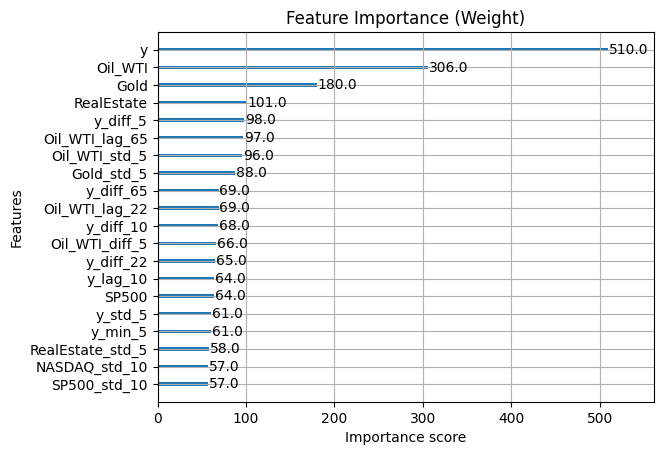

['y', 'Oil_WTI', 'Gold', 'RealEstate', 'y_diff_5', 'Oil_WTI_lag_65', 'Oil_WTI_std_5', 'Gold_std_5', 'Oil_WTI_lag_22', 'y_diff_65', 'y_diff_10', 'Oil_WTI_diff_5']


In [26]:
import matplotlib.pyplot as plt
import xgboost # Import the xgboost module

# Plot feature importance based on "weight" (number of times a feature appears in a tree)
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Weight)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='weight')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_weight_features_list = df_importance['Feature'].head(12).tolist()
print(top_weight_features_list)

<Figure size 1000x600 with 0 Axes>

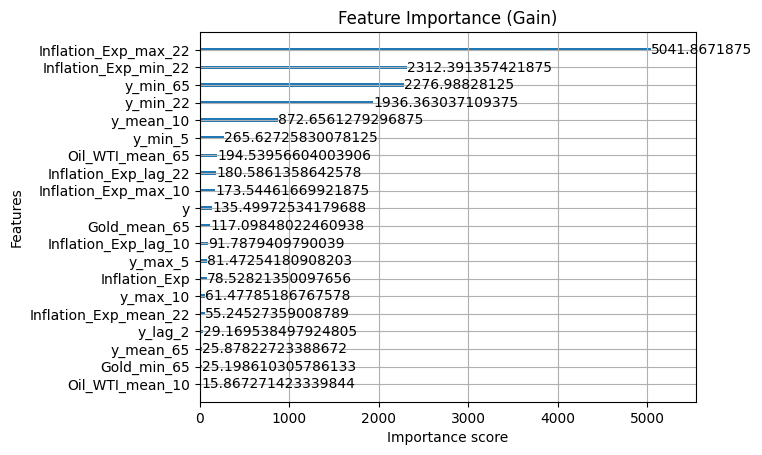

['Inflation_Exp_max_22', 'Inflation_Exp_min_22', 'y_min_65', 'y_min_22', 'y_mean_10', 'y_min_5', 'Oil_WTI_mean_65', 'Inflation_Exp_lag_22', 'Inflation_Exp_max_10', 'y', 'Gold_mean_65', 'Inflation_Exp_lag_10']


In [27]:
# OPTIONAL: Plot based on "gain" (average gain of splits which use the feature)
# "Gain" is often more accurate for finding what actually drives the prediction.
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, importance_type='gain', max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Gain)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='gain')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_gain_features_list = df_importance['Feature'].head(12).tolist()
print(top_gain_features_list)

In [28]:
top_features = list(set(top_gain_features_list) | set(top_weight_features_list))
top_features

['y_min_22',
 'Oil_WTI_lag_22',
 'Oil_WTI_diff_5',
 'y_diff_65',
 'Oil_WTI_mean_65',
 'Inflation_Exp_max_22',
 'Gold',
 'Oil_WTI_lag_65',
 'Inflation_Exp_max_10',
 'Oil_WTI_std_5',
 'Inflation_Exp_lag_10',
 'y_mean_10',
 'Inflation_Exp_min_22',
 'y_min_5',
 'RealEstate',
 'y',
 'Inflation_Exp_lag_22',
 'Gold_mean_65',
 'y_diff_5',
 'Gold_std_5',
 'y_min_65',
 'Oil_WTI',
 'y_diff_10']

# Final df

In [29]:
final_df = df[['Date','y_next'] + top_features]

for col in top_features:
  final_df[f"{col}_orig"] = df[f"{col}_orig"]

display(final_df.tail(1))
final_df.info()

Ticker,Date,y_next,y_min_22,Oil_WTI_lag_22,Oil_WTI_diff_5,y_diff_65,Oil_WTI_mean_65,Inflation_Exp_max_22,Gold,Oil_WTI_lag_65,...,y_min_5_orig,RealEstate_orig,y_orig,Inflation_Exp_lag_22_orig,Gold_mean_65_orig,y_diff_5_orig,Gold_std_5_orig,y_min_65_orig,Oil_WTI_orig,y_diff_10_orig
1096,2025-12-08,1.39,0.038082,0.037104,0.522298,0.581767,0.0,0.764025,0.945008,0.071203,...,1.22,89.190002,1.39,4.157,3981.916906,0.11,12.733395,1.16,58.880001,0.16


<class 'pandas.core.frame.DataFrame'>
Index: 1032 entries, 65 to 1096
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       1032 non-null   datetime64[ns]
 1   y_next                     1032 non-null   float64       
 2   y_min_22                   1032 non-null   float64       
 3   Oil_WTI_lag_22             1032 non-null   float64       
 4   Oil_WTI_diff_5             1032 non-null   float64       
 5   y_diff_65                  1032 non-null   float64       
 6   Oil_WTI_mean_65            1032 non-null   float64       
 7   Inflation_Exp_max_22       1032 non-null   float64       
 8   Gold                       1032 non-null   float64       
 9   Oil_WTI_lag_65             1032 non-null   float64       
 10  Inflation_Exp_max_10       1032 non-null   float64       
 11  Oil_WTI_std_5              1032 non-null   float64       
 12  Inflation_

# CSV

In [30]:
if project_config["dataprep.override_csv"] == '1':
  df_csv_path = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
  final_df.to_csv(df_csv_path)